## Download dataset

In [ ]:
!gdown 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 20.6MB/s]


## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Set fixed random values and computing device

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

## Read the dataset

In [ ]:
data_path = '/content/NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data ['labels']

print(X.shape, y.shape)

(300, 2) (300,)


## Split train/val/test set

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

## Normalizing input features

In [ ]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

## Bulding DataLoader

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [ ]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

## Building MLP network

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    out = self.output(x)
    return out.squeeze(1)

In [ ]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

## Declare loss function and optimizer

In [ ]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## Build a function to calculate accuracy

In [ ]:
def compute_accuracy(y_hat, y_true):
  _, y_hat = torch.max(y_hat, dim=1)
  correct = (y_hat == y_true).sum().item()
  accuracy = correct / len(y_true)
  return accuracy

## Training model

In [ ]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
  train_loss = 0.0
  train_target = []
  train_predict = []
  model.train()

  for X_samples, y_samples in train_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)
    optimizer.zero_grad()
    outputs = model(X_samples)
    loss = criterion(outputs, y_samples)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    train_predict.append(outputs.cpu().detach().cpu())
    train_target.append(y_samples.cpu())

  train_loss /= len(train_loader)
  train_losses.append(train_loss)

  train_predict = torch.cat(train_predict)
  train_target = torch.cat(train_target)
  train_acc = compute_accuracy(train_predict, train_target)
  train_accs.append(train_acc)

  val_loss = 0.0
  val_target = []
  val_predict = []
  model.eval()

  with torch.no_grad():
    for X_samples, y_samples in val_loader:
      X_samples = X_samples.to(device)
      y_samples = y_samples.to(device)
      outputs = model(X_samples)
      val_loss += criterion(outputs, y_samples).item()

      val_predict.append(outputs.cpu())
      val_target.append(y_samples.cpu())

  val_loss /= len(val_loader)
  val_losses.append(val_loss)

  val_predict = torch.cat(val_predict)
  val_target = torch.cat(val_target)
  val_acc = compute_accuracy(val_predict, val_target)
  val_accs.append(val_acc)

  print(f'\nEPOCH {epoch+1}: \t Training loss: {train_loss:.3f}\t Validation loss: {val_loss:.3f}')


EPOCH 1: 	 Training loss: 0.939	 Validation loss: 0.864

EPOCH 2: 	 Training loss: 0.750	 Validation loss: 0.815

EPOCH 3: 	 Training loss: 0.715	 Validation loss: 0.799

EPOCH 4: 	 Training loss: 0.689	 Validation loss: 0.791

EPOCH 5: 	 Training loss: 0.670	 Validation loss: 0.780

EPOCH 6: 	 Training loss: 0.654	 Validation loss: 0.747

EPOCH 7: 	 Training loss: 0.646	 Validation loss: 0.724

EPOCH 8: 	 Training loss: 0.616	 Validation loss: 0.704

EPOCH 9: 	 Training loss: 0.616	 Validation loss: 0.694

EPOCH 10: 	 Training loss: 0.610	 Validation loss: 0.666

EPOCH 11: 	 Training loss: 0.577	 Validation loss: 0.666

EPOCH 12: 	 Training loss: 0.596	 Validation loss: 0.642

EPOCH 13: 	 Training loss: 0.556	 Validation loss: 0.625

EPOCH 14: 	 Training loss: 0.537	 Validation loss: 0.608

EPOCH 15: 	 Training loss: 0.521	 Validation loss: 0.604

EPOCH 16: 	 Training loss: 0.530	 Validation loss: 0.587

EPOCH 17: 	 Training loss: 0.511	 Validation loss: 0.566

EPOCH 18: 	 Training l

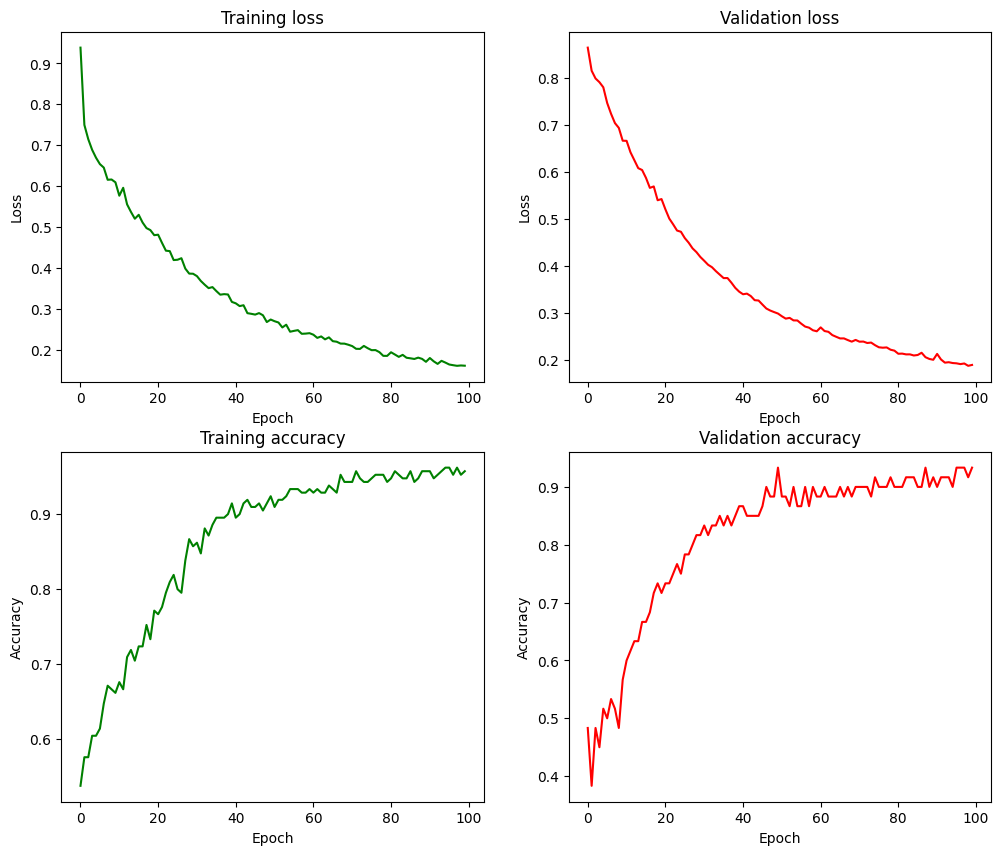

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training loss')

ax[0, 1].plot(val_losses, color='red')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training accuracy')

ax[1, 1].plot(val_accs, color='red')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation accuracy')

plt.show()

## Evaluate model

In [ ]:
test_target = []
test_predict = []
model.eval()

with torch.no_grad():
  for X_samples, y_samples in test_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)
    outputs = model(X_samples)

    test_predict.append(outputs.cpu())
    test_target.append(y_samples.cpu())

  test_predict = torch.cat(test_predict)
  test_target = torch.cat(test_target)
  test_acc = compute_accuracy(test_predict, test_target)

  print('Evaluate on test set:')
  print(f'Test accuracy: {test_acc:.3f}')

Evaluate on test set:
Test accuracy: 0.933
